In [2]:
# import packages and libraries
import pandas as pd
import lightgbm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import uuid
import os
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsRegressor
from modAL.models import ActiveLearner
import random
import sys
from random import randint
import pickle
from datetime import datetime
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt

from modAL.models import ActiveLearner
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

In [3]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i]) ** 2.
    return np.sqrt(residuals / n)

In [4]:
#ensure repetabillity
seed = random.randrange(sys.maxsize)
random.seed(123456)
seed_list = []
for i in range(35):
    seed_list.append(randint(0, 4292967297))
#seed_list

In [5]:
input_file = 'ElctrMotorTemp_ML.txt'
file_object = open(input_file, 'rb')
str_mdl = file_object.read()
model = pickle.loads(str_mdl)

[08:14:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [6]:
# validate on the random predictions from this range
actual_lows = {'ambient': -8.5, 'coolant': -1.4, 'u_d': -1.65, 'u_q': -1.8, 'motor_speed': -1.37,
              'torque': -3.3, 'i_d': -3.2, 'i_q': -3.3}  #, 'pm':[-2.6]}
actual_highs = {'ambient': 2.9, 'coolant': 2.6, 'u_d': 2.27, 'u_q': 1.79, 'motor_speed': 2.02,
              'torque': 3, 'i_d': 1.06, 'i_q': 2.9 }  #, 'pm':[2.9]}
variables_ = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q', 'pm']
samples_ = 10000

def random_generator(samples_, actual_lows, actual_highs, variables_, model):
    df_doe = pd.DataFrame(columns=variables_[:-1])
    for var in variables_[:-1]:
        df_doe[var] = np.random.uniform(actual_lows[var], actual_highs[var],
                                        samples_).round(3)
    try:
        df_doe[variables_[-1]] = model.predict(np.array(df_doe)).round(3)
    except:
        df_doe[variables_[-1]] = model.predict(df_doe).round(3)
    return df_doe

def latin_hypercube_generator(samples_, actual_lows, actual_highs, variables, model):
    # actual_lows = {'AT': [2], 'V': [30], 'AP': [993], 'RH': [30]}  # , 'PE':[425]}
    # actual_highs = {'AT': [35], 'V': [80], 'AP': [1033], 'RH': [100]}  # , 'PE':[495]}
    # variables = ['AT', 'V', 'AP', 'RH', 'PE']
    # samples_ = 100000
    # np.random.seed(5234)
    df_doe = pd.DataFrame(lhs(len(variables) - 1, samples=samples_, criterion='maximin'))
    df_doe.columns = variables[:-1]
    for col in df_doe.columns:
        df_doe[col] = [actual_lows[col]] * df_doe.shape[0] + df_doe[col] * (actual_highs[col] - actual_lows[col])
        df_doe[col] = df_doe[col].apply(lambda x: round(x, 3))
    # df_doe = df_doe.reset_index()
    df_doe.columns = variables[:-1]
    try:
        df_doe[variables_[-1]] = model.predict(np.array(df_doe)).round(3)
    except:
        df_doe[variables_[-1]] = model.predict(df_doe).round(3)
    return df_doe

def normalize(input_array):
    mean = np.mean(input_array, axis=0)
    std = np.std(input_array, axis=0)

    # scikit-learn measure to handle zeros in scale: def _handle_zeros_in_scale(scale, copy=True)
    # https://github.com/scikit-learn/scikit-learn/blob/7389dbac82d362f296dc2746f10e43ffa1615660/sklearn/preprocessing/data.py#L70
    # if np.isscalar(std):
    #     if std == .0:
    #         std = 1.
    # elif isinstance(std, np.ndarray):
    #     std = std.copy()
    #     std[std == 0.0] = 1.0
    min = np.min(input_array, axis=0)
    max = np.max(input_array, axis=0)
    data_norm = (max - input_array) / (max - min)
    #data_norm = (input_array - mean) / std
    return min, max, data_norm


df = random_generator(samples_, actual_lows, actual_highs, variables_, model)
print(df['pm'].min(), df['pm'].max())

-0.838 2.036


Validate

In [7]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import lightgbm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from pyDOE import lhs


cv_folds = 30
seedSize = 50
batchSize_mcs = 5
batchSize_lhc = 5
batchSize_qbc = 5
batchSize_gpr_al = 1
size_train_set = 400

committee_predictor = True
numCommitteeMembers = 3

trainingSetSizes_mcs = np.arange(seedSize, size_train_set+1, batchSize_mcs)
trainingSetSizes_lhc = np.arange(seedSize, size_train_set+1, batchSize_lhc)
# trainingSetSizes_qbc = np.arange(seedSize, size_train_set+1, batchSize_qbc)
# trainingSetSizes_gpr_al = np.arange(seedSize, size_train_set+1, batchSize_gpr_al)
pth = str(Path().cwd().parents[1] / Path('01_Data') / Path('lhc_designs')) + str(Path("/"))

In [8]:
#validation set
size_test_set = 1000
reference_regr = model
np.random.seed(83746293)
test_data = latin_hypercube_generator(size_test_set, actual_lows, actual_highs, variables_, reference_regr)
test_data = np.array(test_data)
# test_data = np.load(pth + 'lhc_test_pumadyn-32_sz_2000_randseed_83746293.npy')
# size_test_set = test_data.shape[0]

# mcs_extension

In [9]:
#count_mcs = 0

In [10]:
#count_mcs = 1
results_random = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('val {}'.format(cv))
    # for trainSize in trainingSetSizes_mcs:
    #for trainSize in range(seedSize, size_train_set+1):
    np.random.seed(seed_list[cv])
    train_data = np.array(random_generator(seedSize-batchSize_mcs, actual_lows, actual_highs, variables_, reference_regr))
    for trainSize in trainingSetSizes_mcs:

        lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]

        train_data_add = np.array(random_generator(batchSize_mcs, actual_lows, actual_highs, variables_, reference_regr))
        train_data = np.concatenate((train_data, train_data_add), axis=0)
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_test = test_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_test = test_data[:, -1].reshape((-1, 1))

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0]:, -1].reshape((-1, 1))


        if committee_predictor:
            learner_list = []
            for i in range(numCommitteeMembers):
                learner_list.append(ActiveLearner(estimator=predictor,
                                                  X_training=X_train_norm,
                                                  y_training=y_train_norm.ravel(),
                                                  #bootstrap_init=True
                                                 ))
            committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #mcs_y = mcs_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        mcs_y = max_data[-1].reshape((-1, 1)) - mcs_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        preds_mcs = np.ravel(mcs_y)
        targets_mcs = np.ravel(y_test)
        r2_val = r2_score(targets_mcs, preds_mcs)
        rmse_val = rmse(targets_mcs, preds_mcs)

        #print('train size mcs {}'.format(trainSize))
        #print(r2_score(targets_mcs, preds_mcs))
        
        results_random.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_random = pd.DataFrame(results_random)

val 0
Total time fold 0 trainSize 400: 0:00:00.251793 
val 1
Total time fold 1 trainSize 400: 0:00:00.263196 
val 2
Total time fold 2 trainSize 400: 0:00:00.277456 
val 3
Total time fold 3 trainSize 400: 0:00:00.267478 
val 4
Total time fold 4 trainSize 400: 0:00:00.294329 
val 5
Total time fold 5 trainSize 400: 0:00:00.266711 
val 6
Total time fold 6 trainSize 400: 0:00:00.295744 
val 7
Total time fold 7 trainSize 400: 0:00:00.390063 
val 8
Total time fold 8 trainSize 400: 0:00:00.316077 
val 9
Total time fold 9 trainSize 400: 0:00:00.277147 
val 10
Total time fold 10 trainSize 400: 0:00:00.279424 
val 11
Total time fold 11 trainSize 400: 0:00:00.283750 
val 12
Total time fold 12 trainSize 400: 0:00:00.298183 
val 13
Total time fold 13 trainSize 400: 0:00:00.317326 
val 14
Total time fold 14 trainSize 400: 0:00:00.333417 
val 15
Total time fold 15 trainSize 400: 0:00:00.293125 
val 16
Total time fold 16 trainSize 400: 0:00:00.278180 
val 17
Total time fold 17 trainSize 400: 0:00:00.26

In [11]:
res_df_random[res_df_random.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,0.274497,0.722075
71,LGBMRegressor,1,50,0.327068,0.605427
142,LGBMRegressor,2,50,0.346037,0.558329
213,LGBMRegressor,3,50,0.345901,0.558678
284,LGBMRegressor,4,50,0.268319,0.734444
355,LGBMRegressor,5,50,0.356437,0.531384
426,LGBMRegressor,6,50,0.324613,0.611328
497,LGBMRegressor,7,50,0.290997,0.687658
568,LGBMRegressor,8,50,0.291907,0.685703
639,LGBMRegressor,9,50,0.299996,0.668043


In [12]:
res_df_random[res_df_random.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
70,LGBMRegressor,0,400,0.148816,0.918314
141,LGBMRegressor,1,400,0.132595,0.935150
212,LGBMRegressor,2,400,0.171241,0.891840
283,LGBMRegressor,3,400,0.159596,0.906050
354,LGBMRegressor,4,400,0.139211,0.928517
425,LGBMRegressor,5,400,0.153088,0.913556
496,LGBMRegressor,6,400,0.141476,0.926173
567,LGBMRegressor,7,400,0.128244,0.939337
638,LGBMRegressor,8,400,0.144642,0.922831
709,LGBMRegressor,9,400,0.142721,0.924868


# lhc

In [13]:
#count_lhc = 0

In [14]:
numCommitteeMembers = 3

results_lhc = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for trainSize in trainingSetSizes_lhc:
        np.random.seed(seed_list[cv])
#         try:
#             fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#             fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#             train_data =  np.load(pth + fname_t)
#             pool_data = np.load(pth + fname_p)
#         except:
#             # print('lhc file not found')
        train_data = np.array(
            latin_hypercube_generator(trainSize, actual_lows, actual_highs, variables_, reference_regr))
        #print(train_data[0])
        pool_data = np.array(latin_hypercube_generator(size_train_set, actual_lows, actual_highs, variables_,
                                  reference_regr))
#             fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
#             fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
#             np.save(pth + fname_t, train_data)
#             np.save(pth + fname_p, pool_data)
        
        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]
        
        # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_pool = pool_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_pool = pool_data[:, -1].reshape((-1, 1))
        X_test = test_data[:, :-1]
        y_test = test_data[:, -1]

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
        y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

        #print(X_train_norm[0])
        # rr_params_v1 = {
        #     'alpha': 5, 'max_iter': 4, 'normalize': False, 'solver': 'lsqr', 'tol': 0.003}
        # predictor = Ridge(**rr_params_v1)

        learner_list=[]
        for i in range(numCommitteeMembers):
            learner_list.append(ActiveLearner(estimator=predictor,
                                              # estimator=sklearn.base.clone(predictor),
                                              X_training=X_train_norm,
                                              y_training=y_train_norm.ravel(),
                                              bootstrap_init=True
                                             ))
        committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)


        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #qbc_y = qbc_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
                    max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        # -------->  SAVING THE PREDICTED AND TARGET VALUES  <------------------
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)

        #print(r2_score(targets_qbc, preds_qbc))
        r2_val = r2_score(targets_qbc, preds_qbc)
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_lhc.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_lhc = pd.DataFrame(results_lhc)

    # count_lhc+=1

seed 0
Total time fold 0 trainSize 400: 0:00:03.583856 
seed 1
Total time fold 1 trainSize 400: 0:00:03.427252 
seed 2
Total time fold 2 trainSize 400: 0:00:03.433907 
seed 3
Total time fold 3 trainSize 400: 0:00:03.402366 
seed 4
Total time fold 4 trainSize 400: 0:00:03.430223 
seed 5
Total time fold 5 trainSize 400: 0:00:03.495654 
seed 6
Total time fold 6 trainSize 400: 0:00:03.420356 
seed 7
Total time fold 7 trainSize 400: 0:00:03.417006 
seed 8
Total time fold 8 trainSize 400: 0:00:03.425525 
seed 9
Total time fold 9 trainSize 400: 0:00:03.386884 
seed 10
Total time fold 10 trainSize 400: 0:00:03.396055 
seed 11
Total time fold 11 trainSize 400: 0:00:03.381360 
seed 12
Total time fold 12 trainSize 400: 0:00:03.371841 
seed 13
Total time fold 13 trainSize 400: 0:00:03.380815 
seed 14
Total time fold 14 trainSize 400: 0:00:03.465211 
seed 15
Total time fold 15 trainSize 400: 0:00:03.482727 
seed 16
Total time fold 16 trainSize 400: 0:00:03.475535 
seed 17
Total time fold 17 trainSi

In [15]:
res_df_lhc[res_df_lhc.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,0.344908,0.561208
71,LGBMRegressor,1,50,0.284354,0.701758
142,LGBMRegressor,2,50,0.288282,0.693460
213,LGBMRegressor,3,50,0.310483,0.644427
284,LGBMRegressor,4,50,0.273461,0.724169
355,LGBMRegressor,5,50,0.274055,0.722969
426,LGBMRegressor,6,50,0.317032,0.629269
497,LGBMRegressor,7,50,0.287920,0.694229
568,LGBMRegressor,8,50,0.279602,0.711642
639,LGBMRegressor,9,50,0.288027,0.694003


In [16]:
res_df_lhc[res_df_lhc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
70,LGBMRegressor,0,400,0.131981,0.935750
141,LGBMRegressor,1,400,0.132592,0.935154
212,LGBMRegressor,2,400,0.131015,0.936687
283,LGBMRegressor,3,400,0.128856,0.938756
354,LGBMRegressor,4,400,0.143096,0.924472
425,LGBMRegressor,5,400,0.131406,0.936309
496,LGBMRegressor,6,400,0.131479,0.936237
567,LGBMRegressor,7,400,0.135692,0.932086
638,LGBMRegressor,8,400,0.132255,0.935483
709,LGBMRegressor,9,400,0.136319,0.931457


# AL with qbc

In [17]:
#count_qbc = 0

In [18]:
# cv_folds = 10

In [19]:
committee_predictor=True

In [20]:
from sklearn.ensemble import RandomForestRegressor

count_qbc= 0
PoolSetSize = 600 #260#260 #400
batchSize = 5
seedSize = 50
n_queries = 70

numCommitteeMembers = 3

results_qbc_t = []
for cv in range(cv_folds):
    learner_list = []
    startTime = datetime.now()
    #est = [100, 120, 140]
    num_leaves = [6,11,16]
    #num_leaves = [8,11,14]
    for i in range(numCommitteeMembers):
        lgbmParams = {  # 'learning_rate': 0.1,
            #'n_estimators': est[i],
            'num_leaves': num_leaves[i],
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': i*100
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
#         predictor = RandomForestRegressor(max_depth=num_leaves[i], 
#                                   random_state=i*100, 
#                                   #n_estimators=100, 
#                                   n_jobs=1)
        learner_list.append(ActiveLearner(estimator=predictor,
                                          # estimator=sklearn.base.clone(predictor),
                                          X_training=X_train_norm,
                                          y_training=y_train_norm.ravel(),
                                          bootstrap_init=True))
    committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)

#     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    np.random.seed(seed_list[cv]) 
    print('seed {}'.format(cv))
    pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))

    # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    #print(X_train_norm[0])


    committee.fit(X_train_norm, y_train_norm.ravel())
     #  -------->  Initial Evaluation  <------------------
    if committee_predictor:
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)

    #print('QBC before, train size {}'.format(X_train_norm.shape[0]))
    #print(r2_score(targets_qbc, preds_qbc))



    for itter in range(n_queries+1):
        #print(itter)
        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)
        #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

        r2_val = r2_score(targets_qbc, preds_qbc)
        #print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                       'RMSE': rmse_val, 'r2_val': r2_val})

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
        X_train = np.append(X_train, X_pool[query_idx], axis=0)
        y_train = np.append(y_train, y_pool[query_idx], axis=0)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
        committee.teach(X_pool_norm[query_idx],
                        y_pool_norm.ravel()[query_idx])  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
        # print(X_pool_norm.shape)
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 0
Total time fold 0 trainSize 405: 0:00:00.514307 
seed 1
Total time fold 1 trainSize 405: 0:00:00.545373 
seed 2
Total time fold 2 trainSize 405: 0:00:00.589667 
seed 3
Total time fold 3 trainSize 405: 0:00:00.557865 
seed 4
Total time fold 4 trainSize 405: 0:00:00.540010 
seed 5
Total time fold 5 trainSize 405: 0:00:00.538183 
seed 6
Total time fold 6 trainSize 405: 0:00:00.530674 
seed 7
Total time fold 7 trainSize 405: 0:00:00.612537 
seed 8
Total time fold 8 trainSize 405: 0:00:00.587866 
seed 9
Total time fold 9 trainSize 405: 0:00:00.537425 
seed 10
Total time fold 10 trainSize 405: 0:00:00.553016 
seed 11
Total time fold 11 trainSize 405: 0:00:00.542030 
seed 12
Total time fold 12 trainSize 405: 0:00:00.584035 
seed 13
Total time fold 13 trainSize 405: 0:00:00.541443 
seed 14
Total time fold 14 trainSize 405: 0:00:00.536360 
seed 15
Total time fold 15 trainSize 405: 0:00:00.543875 
seed 16
Total time fold 16 trainSize 405: 0:00:00.576788 
seed 17
Total time fold 17 trainSi

In [21]:
res_df_qbc[res_df_qbc.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,0.248896,0.771499
71,LGBMRegressor,1,50,0.271332,0.728446
142,LGBMRegressor,2,50,0.263309,0.744268
213,LGBMRegressor,3,50,0.254259,0.761547
284,LGBMRegressor,4,50,0.293166,0.682985
355,LGBMRegressor,5,50,0.295473,0.677975
426,LGBMRegressor,6,50,0.271610,0.727890
497,LGBMRegressor,7,50,0.311346,0.642448
568,LGBMRegressor,8,50,0.313930,0.636489
639,LGBMRegressor,9,50,0.291036,0.687575


In [22]:
res_df_qbc[res_df_qbc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
70,LGBMRegressor,0,400,0.113443,0.952531
141,LGBMRegressor,1,400,0.119245,0.947552
212,LGBMRegressor,2,400,0.127092,0.940421
283,LGBMRegressor,3,400,0.128457,0.939135
354,LGBMRegressor,4,400,0.130204,0.937468
425,LGBMRegressor,5,400,0.136419,0.931356
496,LGBMRegressor,6,400,0.125799,0.941627
567,LGBMRegressor,7,400,0.117719,0.948886
638,LGBMRegressor,8,400,0.127954,0.939611
709,LGBMRegressor,9,400,0.128228,0.939352


# Visualize

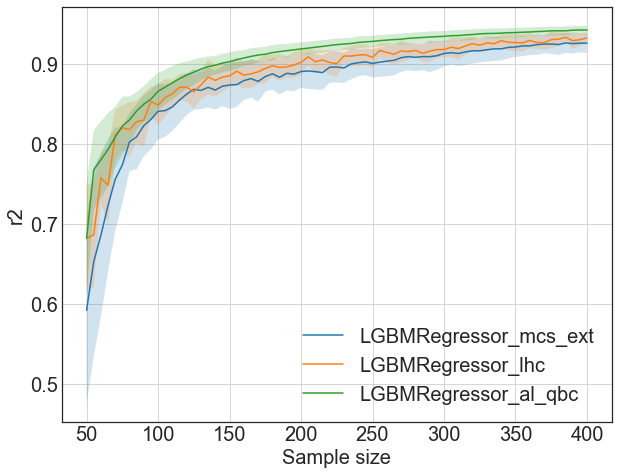

In [25]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)


def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    #plt.title(title)
    plt.grid()
    #plt.figure(figsize=(6,6))
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.savefig('EMT_al_lhc_mcs_results_Bagging_' + mdl + '.png', dpi=300)
        plt.show()

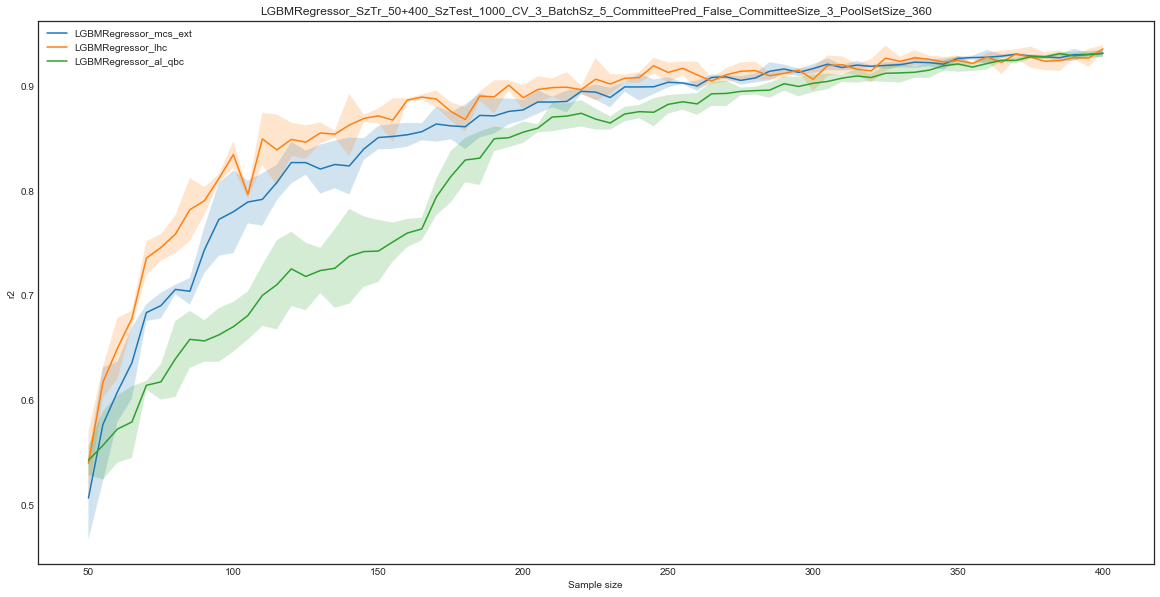

In [229]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

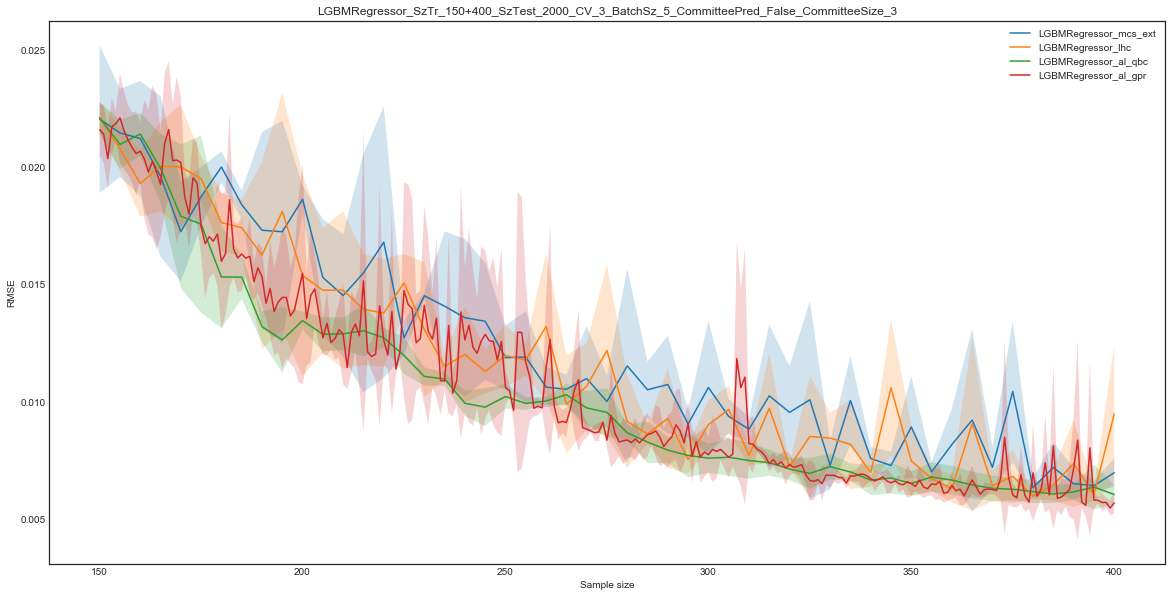

In [146]:
def plot_learning_curve_rmse(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.RMSE, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.RMSE - df_target_std.RMSE,
                     df_target_mean.RMSE + df_target_std.RMSE, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('RMSE')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_rmse(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_rmse(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_rmse(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_rmse(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

# Old GPR

In [69]:
count_gpr = 0

In [70]:
PoolSetSize = 251
seedSize = 150
n_queries = 250

lgbmParams = {  # 'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'regression',
    'n_jobs': 1,
    'random_state': seed_list[count_gpr]
    }

predictor = lightgbm.LGBMRegressor(**lgbmParams)
print('seed {}'.format(count_gpr))
#print('seed {}'.format(count_gpr))
np.random.seed(seed_list[count_gpr])
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

#n_initial = 50
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

committee = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_train_norm, y_training=y_train_norm.ravel()
)
#committee.fit(X_train_norm, y_train_norm.ravel())
qbc_y_norm = committee.predict(X_test_norm)
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))

preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
r2_score(targets_qbc, preds_qbc)



import warnings
warnings.filterwarnings("ignore")

#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR before, train size {}'.format(X_train_norm.shape[0]))
#print(X_train_norm[0])
print(r2_score(targets_qbc, preds_qbc))
      
#np.random.seed(12345)
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool_norm)
    #print(X_pool_norm[0])
#     print(query_idx)
#     print(query_instance)
    
    #X_train = np.append(X_train, X_pool[query_idx].reshape(1,-1), axis=0)
    #y_train = np.append(y_train, y_pool[query_idx].reshape(1,-1), axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
    
    committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    
#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR after, train size {}'.format(X_train_norm.shape[0]))
print(r2_score(targets_qbc, preds_qbc))
count_gpr += 1

seed 1
AL GPR before, train size 150
0.2847234742263258
AL GPR after, train size 400
0.9459554964591618


# Tune QBC

In [32]:
count_qbc= 0

In [23]:
count_qbc= 2
PoolSetSize = 260 #400
batchSize = 5
seedSize = 150
n_queries = 50

numCommitteeMembers = 3

results_qbc_t = []
learner_list = []
results_qbc_t = []

startTime = datetime.now()
for i in range(numCommitteeMembers):
    lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': i*100
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)
    learner_list.append(ActiveLearner(estimator=predictor,
                                      # estimator=sklearn.base.clone(predictor),
                                      X_training=X_train_norm,
                                      y_training=y_train_norm.ravel(),
                                      #bootstrap_init=True
                                     ))
committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
np.random.seed(seed_list[count_qbc])
print('seed {}'.format(count_qbc))
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#print(train_data[0])
#np.random.seed(seed_list[cv])
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
#print(pool_data[0])
print('1')
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
print('1')


committee.fit(X_train_norm, y_train_norm.ravel())
 #  -------->  Initial Evaluation  <------------------
if committee_predictor:
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = committee.predict(X_test_norm)
else:
    #  -------->  MODEL FITTING  <------------------
    predictor.fit(X_train_norm, y_train_norm.ravel())
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = predictor.predict(X_test_norm)
print('1')
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)

#print('QBC before, train size {}'.format(X_train_norm.shape[0]))
#print(r2_score(targets_qbc, preds_qbc))



for itter in range(n_queries+1):
    #print(itter)
    if committee_predictor:
        #  -------->  MODEL FITTING  <------------------
        committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)
    #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

    r2_val = r2_score(targets_qbc, preds_qbc)
    print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
    rmse_val = rmse(targets_qbc, preds_qbc)

    results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                   'RMSE': rmse_val, 'r2_val': r2_val})

    # -------->  Pick new point  <------------------
    query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
    X_train = np.append(X_train, X_pool[query_idx], axis=0)
    y_train = np.append(y_train, y_pool[query_idx], axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
    committee.teach(X_pool_norm[query_idx],
                    y_pool_norm.ravel()[query_idx])  # train committee on newly added data
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    # print(X_pool_norm.shape)

endTime = datetime.now()
print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 2
1
1
1
size 150, r2 0.35445386655170497
size 155, r2 0.340873770610048
size 160, r2 0.38841403268328645
size 165, r2 0.3864077306869165
size 170, r2 0.4390538958775101
size 175, r2 0.5588433343854644
size 180, r2 0.5095936092298412
size 185, r2 0.6942965612891441
size 190, r2 0.7167600911786798
size 195, r2 0.7644677264409534
size 200, r2 0.6572942766775371
size 205, r2 0.7828379240048782
size 210, r2 0.7918665687182542
size 215, r2 0.7886589649560223
size 220, r2 0.8171275667250548
size 225, r2 0.8138557154221708
size 230, r2 0.8127679410582134
size 235, r2 0.8338991422011794
size 240, r2 0.8369270601832728
size 245, r2 0.8487277747863331
size 250, r2 0.8823386245033785
size 255, r2 0.8837254795285228
size 260, r2 0.9076315463111355
size 265, r2 0.8849960580669709
size 270, r2 0.9055399258336457
size 275, r2 0.8920317275598293
size 280, r2 0.8733776113192481
size 285, r2 0.911010074672587
size 290, r2 0.8983539639679428
size 295, r2 0.8971737226492815
size 300, r2 0.905383316304

In [111]:
np.random.seed(seed_list[4])
train_data = np.array(latin_hypercube_generator(150, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(250, actual_lows, actual_highs, variables_, reference_regr))
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

X_t = np.concatenate((X_train_norm, X_pool_norm), axis=0)
y_t = np.concatenate((y_train_norm, y_pool_norm), axis=0)
predictor.fit(X_t, y_t.ravel())

bc_y_norm = predictor.predict(X_test_norm)

# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
#print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))
#print(r2_score(targets_qbc, preds_qbc))

r2_val = r2_score(targets_qbc, preds_qbc)
print('size {}, r2 {}'.format(X_t.shape[0], r2_val))

size 400, r2 0.9359631045189958


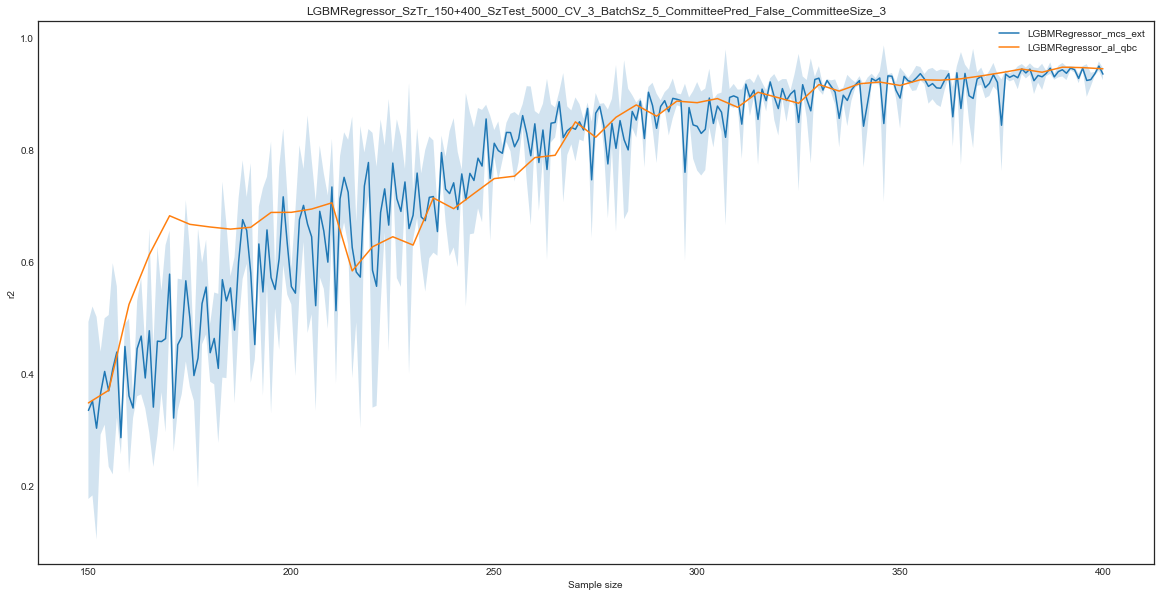

In [34]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

In [10]:
for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

NameError: name 'res_df_random' is not defined